# EDA (Exploratory Data Analysis)

## 목적
본 EDA는 정책/복지 데이터의 품질과 분포를 점검하여  
(1) 전처리 우선순위, (2) 텍스트 기반 피처 구성 방향, (3) 모델링 전략을 결정하기 위한 근거를 확보하고자 함

## 데이터 개요
- 데이터 형태: JSON → DataFrame 로드
- 주요 컬럼(예): 정책명, 지원내용, 대분류, 중분류, 정책설명, 주관기관명/등록기관명, 지원최소연령/지원최대연령 등
- 총 레코드 수: 3,550건

## 이번 EDA에서 확인할 핵심 질문
1. 정책명/지원내용 등 핵심 텍스트 필드에 결측/빈값이 존재하는가?
2. 정책 정보가 중복되어 학습/검색 품질을 저해할 가능성은 없는가?
3. 텍스트 길이 분포는 어떠하며, 과도하게 긴/짧은 문서는 어떻게 처리할 것인가?
4. 대분류/중분류/기관/지역 컬럼의 분포 및 표준화 필요성은 어느 정도인가?
5. 연령 필드는 수치형 해석이 가능한 형태로 정리 가능한가?
6. 키워드 빈도 관찰을 통해 불용어/정규화 전략 설계 힌트를 얻을 수 있는가?

## 산출물
- EDA 노트북
- 요약 지표 파일: `eda_summary.csv`
- 전처리 우선순위 표 및 최종 결론

In [18]:
# 환경 설정 셀
import json
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

sns.set(style="whitegrid")

# 프로젝트 루트 동적 설정 (노트북 위치 기준)
# notebooks/eda.ipynb 실행 시, 상위 디렉토리가 프로젝트 루트
notebook_dir = Path.cwd()  # 현재 작업 디렉토리
# 만약 notebooks/ 안에서 실행되면, notebooks 상위가 프로젝트 루트
if notebook_dir.name == "notebooks":
    project_root = notebook_dir.parent
else:
    # VSCode에서 프로젝트 루트를 열었으면 그것이 cwd
    project_root = notebook_dir

data_file = project_root / "data" / "processed" / "youth_policies_filtered_kr_revised.json"

print(f"프로젝트 루트: {project_root}")
print(f"데이터 파일 경로: {data_file}")
print(f"파일 존재 여부: {data_file.exists()}")

if not data_file.exists():
    print(f"\n⚠️  파일을 찾을 수 없습니다. 경로를 다시 확인하세요.")
    print(f"   현재 작업 디렉토리: {Path.cwd()}")


# 한글 폰트 설정 (Windows/Mac/Linux 자동 감지 및 대체)
import platform
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.font_manager as fm

def set_korean_font():
    system = platform.system()
    # 플랫폼별 권장 한글 폰트 이름
    if system == "Windows":
        prefer = ["Malgun Gothic", "맑은 고딕"]
    elif system == "Darwin":
        prefer = ["AppleGothic"]
    else:
        # Linux: 보통 Nanum 계열 설치 권장
        prefer = ["NanumGothic", "Nanum Gothic", "UnDotum", "Ubuntu"]
    available = {f.name for f in fm.fontManager.ttflist}
    chosen = None
    for name in prefer:
        if name in available:
            chosen = name
            break
    if not chosen:
        # fallback
        chosen = "DejaVu Sans"
    mpl.rc('font', family=chosen)
    mpl.rcParams['axes.unicode_minus'] = False
    print(f"Matplotlib font set to: {chosen}")

# 실행
set_korean_font()


프로젝트 루트: c:\Users\playdata2\Desktop\SKN20-3rd-1TEAM-main
데이터 파일 경로: c:\Users\playdata2\Desktop\SKN20-3rd-1TEAM-main\data\processed\youth_policies_filtered_kr_revised.json
파일 존재 여부: True
Matplotlib font set to: Malgun Gothic


In [ ]:
# 데이터 로드 및 기본 확인
with open(data_file, 'r', encoding='utf-8') as f:
    raw = json.load(f)
df = pd.DataFrame(raw)
df.head(5)

,정책명,정책키워드,정책설명,대분류,중분류,지원내용,최소지원금액,최대지원금액,지원최소연령,지원최대연령,...,신청방법,제출서류,선정방법,신청URL,추가자격조건,참여제외대상,상위기관명,상위등록기관명,참고URL2,운영기관명
0,청년 커뮤니티(동아리) 활성화 지원사업,보조금,"청년들의 모음 활성화, 이를 통한 지역청년의 유대감 형성, 청년들에게 공동체 의식 ...",복지문화,문화활동,"커뮤니티 지원 1,000천원 이내 활동경비 지원",0,0,19,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,남해군 청년주택 임차보증금 이자지원사업,"주거지원,대출",2024. 7. 1. ~ 2025. 6. 30.기간 중 납부한 주택 임차보증금 이자...,주거,전월세 및 주거급여 지원,2024. 7. 1. ~ 2025. 6. 30.기간 중 납부한 주택 임차보증금 이자...,0,0,19,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,진주시 대학생 행정인턴사업,"인턴,맞춤형상담서비스","겨울방학 동안 대학생들에게 다양한 행정 분야 등을 체험하고, 지역을 위해 봉사할 수...",일자리,취업,2026년 겨울방학 대학생 행정인턴사업 참여자 모집\n ❍ 근무기간 : 2026....,0,0,0,0,...,❍ 신청방법 : 진주시 청년온라인플랫폼 접속 후 신청\n,"❍ 신청서류 : 재학증명서, 주민등록초본, *우선선발 증빙서류(해당자)\n ...",❍ 선발일자 : 2025. 12. 12.(금) 11:00 예정\n❍ 선발방법 : 진...,https://young.jinju.go.kr/young/,신청자격(공고일 기준)\n▸ 지역 기준(공통)\n - 진주시에 주소를 두고 있는...,"제외 대상 : 휴학생, 중퇴생, 졸업생, 대학원생, 방송통신대학생, 전산원 학생, ...",NaN,NaN,NaN,NaN
3,전남형 청년마을 조성사업,보조금,지역 청년이 주도적으로 전남형 청년마을 조성하여 주민과 상생협력하는 청년 지원의 선...,참여권리,정책인프라구축,"□ 지원금액 : 개소당 3억원\n ❍ (1년차) 2억원, (2년차) 1억원\n* ...",0,0,18,45,...,□ 제출방법 : 시․군 → 道(청년희망과) 공문 제출\n ❍ 청년단체\n -...,① 사업신청서 \n② 사업계획서\n③ 수행기관 일반현황 및 연혁\n④ 지역사회(...,"□ 선정방법 : 1차 서류심사, 2차 현지실사 및 발표심사\n ❍ 1차 서류심사\...",NaN,청년단체․기업(사업자등록증이 있는 경우만 가능),NaN,전라남도,전라남도,https://www.jnyouthcenter.kr/bbs/board.php?bo_...,NaN
4,청년 취업자 주거비 지원사업,보조금,전･월세 주거비 지원으로 청년의 주거 안정과 경제적 자립을 지원합니다.,주거,전월세 및 주거급여 지원,"전･월세 월 20만원, 최대 12개월(240만원, 생애 1회) 지원",0,0,18,45,...,"① 신청서류 접수(읍･면･동)\n② 자격요건 확인 및 대상자 확정(LH, 시⋅군)\...",① 청년 취업자 주거비 지원 신청서\n② 개인정보 수집 및 이용 동의서\n③ 사회보...,NaN,NaN,- (노동자) 공고일 기준 최근 6개월 동안 3개월(90일) 이상 노동 중인 자\n...,"공무원 및 공공기관 임직원, 공무직, 군복무자, 사치·향락·도박·사행 등 비사회적 ...",전라남도,전라남도,https://www.jnyouthcenter.kr/bbs/board.php?bo_...,NaN


## 스키마/결측치 1차 관찰

- 핵심 텍스트 필드(정책명/지원내용)는 현재 요약 기준 결측이 거의 없었음  
  (정책명 결측 0건, 지원내용 결측 0건)
- 다만 텍스트 기반 데이터의 특성상 **결측 외에도 '공백/의미 없는 문자열'**이 존재할 수 있어  
  후속 단계에서 빈값/공백 검증을 동일하게 수행
- 기타 메타데이터 컬럼은 기관/지역/연령 등 표준화 여부에 따라  
  모델 입력 품질이 달라질 수 있으므로 분포 확인 후 전처리 원칙을 결정

In [ ]:
# 스키마, 결측치 요약
df.info()
missing = df.isna().sum().sort_values(ascending=False)
missing_percent = (missing/len(df))*100
pd.concat([missing, missing_percent], axis = 1, keys=['missing_count', 'missing_pct']).head(30)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3550 entries, 0 to 3549
Data columns (total 38 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   정책명      3550 non-null   object
 1   정책키워드    1789 non-null   object
 2   정책설명     3550 non-null   object
 3   대분류      3515 non-null   object
 4   중분류      3515 non-null   object
 5   지원내용     3550 non-null   object
 6   최소지원금액   1493 non-null   object
 7   최대지원금액   1493 non-null   object
 8   지원최소연령   2758 non-null   object
 9   지원최대연령   2708 non-null   object
 10  주관기관명    3545 non-null   object
 11  등록기관명    3529 non-null   object
 12  신청기간     2169 non-null   object
 13  사업시작일    1101 non-null   object
 14  사업종료일    1101 non-null   object
 15  참고URL1   2428 non-null   object
 16  재공기관그룹   3550 non-null   object
 17  정책제공방법   1539 non-null   object
 18  정책승인상태   3550 non-null   object
 19  신청기간구분   3550 non-null   object
 20  사업기간구분   1536 non-null   object
 21  혼인상태     1549 non-null   object
 22  

,missing_count,missing_pct
기타지원조건,3356,94.535211
참고URL2,3048,85.859155
사업종료일,2449,68.985915
사업시작일,2449,68.985915
신청URL,2202,62.028169
참여제외대상,2116,59.605634
최대지원금액,2057,57.943662
최소지원금액,2057,57.943662
소득조건,2021,56.929577
사업기간구분,2014,56.732394


In [ ]:
# 핵심 필드(정책명/지원내용) 점검 - 결측/빈값 확인
core_fields = ['정책명', '지원내용']
for c in core_fields:
    empty = df[c].apply(lambda x: (not bool(str(x).strip()))).sum()
    print(f"{c} 빈값/공백 : {empty} ({empty/len(df)*100:.2f}%)")

# 샘플 출력(빈값 있는 행)
df[df['정책명'].isna() | df['정책명'].str.strip().eq("")].head(10)

정책명 빈값/공백 : 0 (0.00%)
지원내용 빈값/공백 : 0 (0.00%)


,정책명,정책키워드,정책설명,대분류,중분류,지원내용,최소지원금액,최대지원금액,지원최소연령,지원최대연령,...,신청방법,제출서류,선정방법,신청URL,추가자격조건,참여제외대상,상위기관명,상위등록기관명,참고URL2,운영기관명


In [22]:
# 6. 중복 확인
# 정책명 + 지원내용 중복 (간단 체크)
dup_by_name = df.duplicated(subset=['정책명']).sum()
dup_by_content = df.duplicated(subset=['지원내용']).sum()
print(f"정책명 중복 개수: {dup_by_name} ({dup_by_name/len(df)*100:.2f}%)")
print(f"지원내용 중복 개수: {dup_by_content} ({dup_by_content/len(df)*100:.2f}%)")

정책명 중복 개수: 103 (2.90%)
지원내용 중복 개수: 86 (2.42%)


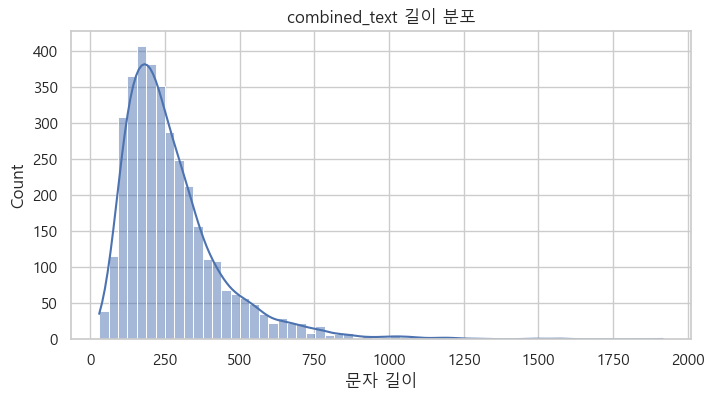

,정책명,text_len
1867,우석대학교 「W_직무페스타」 안내,30
1513,공정거래위원회 2030 자문단,32
1514,익산청년시청 이미지 컨설팅 참여자 모집,33
1986,2024년 남원청년마루 창업공간 입주자 모집,35
109,대학기숙사 확충,35
1628,2024년도 미래인재특기 장학생 선발 공고,37
1708,부싯돌 창업 나들이,37
1725,전북특별자치도 청년 군복무 상해보험 안내,37
1982,2024년 청년 희망틔움2 창업 지원사업 추가모집,38
1510,2025 전북특별자치도 블로그 기자단 모집,39


In [23]:
# 간단한 결합 텍스트(EDA용)
text_cols = ['정책명','대분류','중분류','정책설명','지원내용']
for c in text_cols:
    if c not in df.columns:
        df[c] = ''

df['combined_text'] = df[text_cols].fillna('').agg(' '.join, axis=1).str.replace('\n',' ',regex=False)
df['text_len'] = df['combined_text'].str.len()

df['text_len'].describe()
plt.figure(figsize=(8,4))
sns.histplot(df['text_len'], bins=60, kde=True)
plt.title("combined_text 길이 분포")
plt.xlabel("문자 길이")
plt.show()

# 긴 문서/짧은 문서 샘플
df.sort_values('text_len', ascending=False)[['정책명','text_len']].head(10)
df.sort_values('text_len', ascending=True)[['정책명','text_len']].head(10)

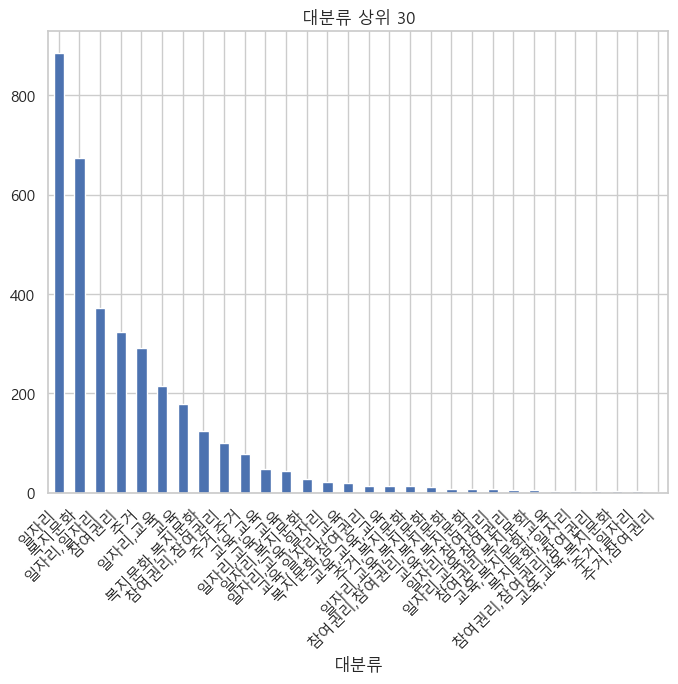

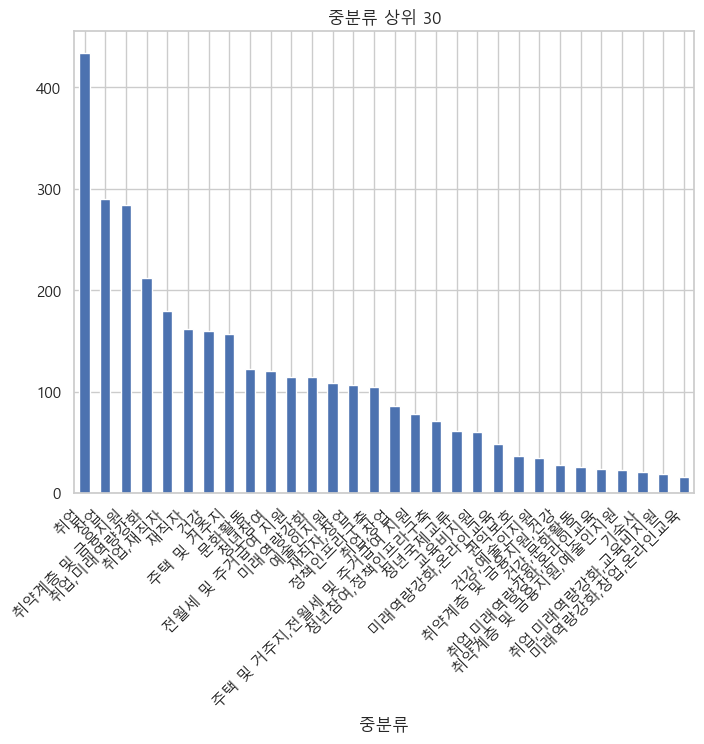

In [ ]:
# 카테고리(대분류/중분류) 분포
for col in ['대분류','중분류']:
    if col in df.columns:
        vc = df[col].value_counts().head(30)
        plt.figure(figsize=(8,6))
        vc.plot.bar()
        plt.title(f"{col} 상위 30")
        plt.xticks(rotation=45, ha='right')
        plt.show()

In [ ]:
# 지역/주관기관 분포 (등록기관명, 상위등록기관명 등)
for col in ['주관기관명', '등록기관명', '제공기관그룹']:
    if col in df.columns:
        print(col)
        print(df[col].value_counts().head(20))
        print()

주관기관명
주관기관명
고용노동부        81
울산광역시        75
충청북도         47
청년정책담당관      45
경상북도         42
청년정책과        41
보건복지부        40
전북특별자치도      38
강원특별자치도      37
중소벤처기업부      33
국토교통부        31
부산광역시        30
-            28
전라남도         26
교육부          24
대구광역시        23
과학기술정보통신부    22
경기도          20
서산시          18
농림축산식품부      18
Name: count, dtype: int64

등록기관명
등록기관명
울산광역시            117
경상남도             107
서울특별시            106
전북특별자치도           94
울산광역시 기업투자국       87
경상남도 교육청년국        80
광주광역시             79
충청남도              76
경상남도 창원시          75
경기도               73
대구광역시             67
제주특별자치도           62
세종특별자치시 기획조정실     56
강원특별자치도           55
인천광역시             53
충청북도              51
한국고용정보원           49
전라남도              47
제주특별자치도 기획조정실     45
울산광역시 남구          40
Name: count, dtype: int64



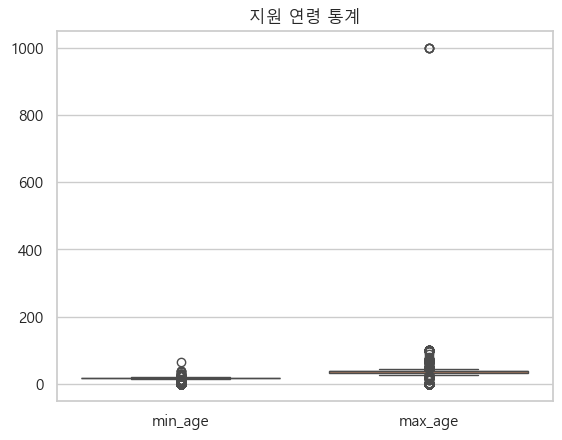

In [26]:
# 연령 필드가 문자열인 경우 정수화 시도
def safe_int(x):
    try:
        return int(x)
    except:
        return np.nan

if '지원최소연령' in df.columns and '지원최대연령' in df.columns:
    df['min_age'] = df['지원최소연령'].replace('', '0').apply(safe_int)
    df['max_age'] = df['지원최대연령'].replace('', '0').apply(safe_int)
    df[['min_age','max_age']].describe()
    sns.boxplot(data=df[['min_age','max_age']])
    plt.title("지원 연령 통계")
    plt.show()

In [ ]:
# 키워드 빈도 (간단 토큰화)
# 간단한 영어/한국어 혼합에서 whitespace 토크나이저 사용 예
sample_texts = df['combined_text'].dropna().astype(str).tolist()[:1000]  # 속도 조절
tokens = []
for t in sample_texts:
    tokens.extend([w for w in t.split() if len(w)>1])
cnt = Counter(tokens)
for word, c in cnt.most_common(40):
    print(word, c)

# 한국어 형태소 분석 권장 (선택)
# from konlpy.tag import Okt
# okt = Okt()
# tokens = []
# for t in sample_texts[:500]:
#     tokens.extend([m for m, pos in okt.pos(t) if pos in ("Noun","Verb","Adjective")])
# Counter(tokens).most_common(40)

지원 1084
청년 852
일자리 467
운영 407
취업 288
위한 278
복지문화 262
교육 251
통한 224
지역 222
창업 218
프로그램 201
제공 192
통해 190
사업 170
최대 166
대상 151
있는 142
청년의 142
이상 141
맞춤형 139
지원사업 138
취약계층 134
주거 132
도내 130
금융지원 130
참여권리 129
또는 114
지급 114
1. 106
양성 101
이하 100
분야 92
참여 89
등) 88
강화 87
미래역량강화 87
대한 84
청년들의 83
활동 82


## 전처리 우선순위 결정

아래 우선순위는 EDA 결과를 기반으로  
**검색/분류/요약 등 텍스트 모델 성능과 데이터 신뢰도에 미치는 영향도**를 중심으로 결정

| 이슈 | EDA 관찰 근거 | 영향 | 처리 원칙(초안) | 우선순위 |
|---|---|---|---|---|
| 핵심 필드 결측/빈값 | 정책명/지원내용 결측은 현재 요약 기준 0건이나, 공백/의미 없는 문자열 가능성 존재 | 핵심 텍스트 품질 저하 | 공백/빈문자열을 결측으로 간주 후 제거 또는 보완 |
| 중복 데이터 | 정책명/지원내용 단위 중복 가능성 확인 | 검색/학습 편향, 성능 착시 | 기준 컬럼(정책명, 지원내용)별 중복 정의 후 제거 규칙 수립 |
| 텍스트 길이 극단값 | 결합 텍스트 평균 약 275자, 중앙값 231자 *(요약 기준)* | 너무 긴 문서는 노이즈/비용 증가, 너무 짧은 문서는 정보 부족 | 상하위 극단값 확인 후 컷오프 또는 요약/분리 전략 |
| 대/중분류 희소 | 상위 분포 집중 가능성 | 라벨 불균형/희소 카테고리 노이즈 | 희소 카테고리 묶기/기타 처리 또는 샘플링 고려 |
| 기관/지역 표기 불일치 | 동일 기관의 다양한 표기 가능성 | 통계/필터/검색 정확도 저하 | 문자열 정규화(공백/특수문자/표기 통일) 사전 구축 |
| 연령 필드 타입 혼재 | 문자열/빈값 등 존재 가능 | 조건 필터/추천 로직 오류 | 안전한 정수 변환 + 범위 검증 + 결측 처리 |
| 키워드 노이즈 | 단순 토큰화 시 불용어 포함 가능 | 검색/요약 품질 저하 | 불용어 리스트 + 형태소 기반 토큰화(선택) |

### 전처리 결정이 모델링에 미치는 연결 포인트
- 중복 제거/표준화 - **검색 기반(RAG/추천) 품질**에 직접 영향
- 텍스트 길이 컷오프/정규화 - **임베딩 품질 및 비용/속도**에 영향
- 분류 라벨(대/중분류) 정리 - **라벨 불균형 대응 전략**과 함께 설계


In [30]:
import pandas as pd
import numpy as np
import re
import json

# =========================
# 0) 유틸 함수
# =========================

def col_exists(df, col):
    return col in df.columns

def safe_col(df, col):
    if col_exists(df, col):
        return df[col]
    return pd.Series([], dtype="object")

def count_blank_like(s: pd.Series) -> int:
    """NaN이 아니라도 공백/의미없는 문자열을 빈값으로 집계"""
    if s.empty:
        return 0
    # 문자열로 안전 변환 후 strip
    return (
        s.fillna("")
         .astype(str)
         .str.strip()
         .eq("")
         .sum()
    )

def to_int_safe(x):
    """문자열/혼합 타입에서 숫자만 뽑아 정수 변환"""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    # 숫자만 남기기
    s = re.sub(r"[^\d]", "", s)
    if s == "":
        return np.nan
    try:
        return int(s)
    except:
        return np.nan

def top_k_summary(s: pd.Series, k=5):
    """상위 k개 카테고리 요약 {value: count} 반환"""
    if s.empty:
        return {}
    vc = s.dropna().astype(str).str.strip()
    vc = vc[vc != ""].value_counts().head(k)
    return vc.to_dict()

def jsonable(v):
    """csv 저장용으로 dict/list 등은 json string으로 변환"""
    if isinstance(v, (dict, list, tuple)):
        return json.dumps(v, ensure_ascii=False)
    return v

# =========================
# 1) 핵심 컬럼 후보 정의
# =========================

# 텍스트 핵심 후보 (있는 것만 자동 사용)
TEXT_COL_CANDIDATES = [
    "정책명", "지원내용", "정책설명", "지원요건", "신청방법",
    "사업내용", "대상", "혜택", "문의처"
]

# 분류/기관/지역 후보
CAT_COL_CANDIDATES = [
    "대분류", "중분류", "소분류",
    "주관기관명", "등록기관명", "운영기관",
    "지역", "시도", "시·도", "구군", "시군구"
]

# 연령 후보
MIN_AGE_CANDIDATES = ["지원최소연령", "최소연령", "min_age", "MinAge"]
MAX_AGE_CANDIDATES = ["지원최대연령", "최대연령", "max_age", "MaxAge"]

# =========================
# 2) 실제 존재 컬럼만 필터링
# =========================

text_cols = [c for c in TEXT_COL_CANDIDATES if col_exists(df, c)]
cat_cols  = [c for c in CAT_COL_CANDIDATES if col_exists(df, c)]
min_age_col = next((c for c in MIN_AGE_CANDIDATES if col_exists(df, c)), None)
max_age_col = next((c for c in MAX_AGE_CANDIDATES if col_exists(df, c)), None)

# =========================
# 3) 기본 규모 지표
# =========================

rows = int(len(df))
cols = int(df.shape[1])

# =========================
# 4) 결측/공백 품질 지표
# =========================

missing_report = {}
blank_report = {}

for c in text_cols + cat_cols:
    s = safe_col(df, c)
    missing_report[c] = int(s.isna().sum())
    blank_report[c] = int(count_blank_like(s))

# =========================
# 5) 중복 지표
# =========================

dup_all_rows = int(df.duplicated().sum())

# 정책 관련 중복 기준 후보
dup_subset_candidates = [c for c in ["정책명", "지원내용"] if col_exists(df, c)]
dup_by_subset = None

if len(dup_subset_candidates) >= 1:
    dup_by_subset = int(df.duplicated(subset=dup_subset_candidates).sum())

# =========================
# 6) 텍스트 길이 분포
# =========================

text_len_stats = {}

if len(text_cols) >= 1:
    combined = pd.Series([""] * len(df))
    for c in text_cols:
        combined = combined + safe_col(df, c).fillna("").astype(str)

    lengths = combined.astype(str).str.len()

    text_len_stats = {
        "combined_cols": text_cols,
        "min": int(lengths.min()),
        "p10": float(lengths.quantile(0.10)),
        "median": float(lengths.median()),
        "mean": float(lengths.mean()),
        "p90": float(lengths.quantile(0.90)),
        "max": int(lengths.max())
    }

# =========================
# 7) 카테고리 상위값
# =========================

top_categories = {}
for c in cat_cols:
    top_categories[c] = top_k_summary(safe_col(df, c), k=5)

# =========================
# 8) 연령 필드 요약(있을 때만)
# =========================

age_stats = {}
if min_age_col:
    min_age_num = safe_col(df, min_age_col).apply(to_int_safe)
    age_stats["min_age_col"] = min_age_col
    age_stats["min_age_missing"] = int(min_age_num.isna().sum())
    age_stats["min_age_min"] = float(min_age_num.min()) if min_age_num.notna().any() else None
    age_stats["min_age_median"] = float(min_age_num.median()) if min_age_num.notna().any() else None
    age_stats["min_age_max"] = float(min_age_num.max()) if min_age_num.notna().any() else None

if max_age_col:
    max_age_num = safe_col(df, max_age_col).apply(to_int_safe)
    age_stats["max_age_col"] = max_age_col
    age_stats["max_age_missing"] = int(max_age_num.isna().sum())
    age_stats["max_age_min"] = float(max_age_num.min()) if max_age_num.notna().any() else None
    age_stats["max_age_median"] = float(max_age_num.median()) if max_age_num.notna().any() else None
    age_stats["max_age_max"] = float(max_age_num.max()) if max_age_num.notna().any() else None

# =========================
# 9) report 확장
# =========================

# 기존 report가 이미 있으면 update 방식으로 붙이기
try:
    report
except NameError:
    report = {}

report.update({
    "rows": rows,
    "cols": cols,
    "text_cols_used": text_cols,
    "cat_cols_used": cat_cols,
    "missing_counts": missing_report,
    "blank_like_counts": blank_report,
    "duplicate_all_rows": dup_all_rows,
    "duplicate_by_subset_cols": dup_subset_candidates if dup_subset_candidates else None,
    "duplicate_by_subset": dup_by_subset,
    "text_length_stats": text_len_stats if text_len_stats else None,
    "top_categories": top_categories if top_categories else None,
    "age_stats": age_stats if age_stats else None,
})

# =========================
# 10) CSV 요약 저장 형태 (key-value)
# =========================

summary_kv = []
for k, v in report.items():
    summary_kv.append({"metric": k, "value": jsonable(v)})

eda_summary_df = pd.DataFrame(summary_kv)

# 기존 저장 코드가 있다면 아래 1줄만 교체해도 OK
eda_summary_df.to_csv("eda_summary.csv", index=False, encoding="utf-8-sig")

eda_summary_df.head(20)

,metric,value
0,total_records,3550
1,missing_policyname,0
2,missing_support,0
3,avg_text_len,274.940563
4,median_text_len,231
5,rows,3550
6,cols,42
7,text_cols_used,"[""정책명"", ""지원내용"", ""정책설명"", ""신청방법""]"
8,cat_cols_used,"[""대분류"", ""중분류"", ""주관기관명"", ""등록기관명""]"
9,missing_counts,"{""정책명"": 0, ""지원내용"": 0, ""정책설명"": 0, ""신청방법"": 980, ..."


## EDA 결론 요약

1. 핵심 텍스트 필드(정책명/지원내용)는 결측이 거의 없으나, **공백/무의미 문자열 검증 후 정제** 수행  
2. **정책명/지원내용 기반 중복 제거 규칙**을 확정하여 학습 및 검색 편향 최소화
3. 텍스트 길이 분포를 기준으로 **극단값 컷오프 또는 요약/분리 전략** 적용  
4. 대/중분류, 기관/지역 컬럼은 **희소/표기 불일치 가능성**을 고려하여 정규화와 범주 통합 원칙 수립  
5. 연령 필드는 안전한 정수화 및 범위 검증을 통해 **조건 기반 필터/추천 로직의 안정성** 확보


본 EDA 결과는 preprocess 단계에 반영되어 clean dataset을 생성한 뒤 임베딩/VectorDB 구축에 사용됨  
특히 정책명·지원내용 기반 중복 제거, 공백/무의미 문자열 정제, 기관/지역 표준화, 연령 필드 수치화 규칙을 우선 적용  
임베딩 입력 텍스트는 정책명+지원내용(+선택적으로 정책설명/요건)을 결합한 combined_text를 기준으로 길이 분포와 컷오프를 설정